# Cancer Type Classification using Deep-Learning
## S.Ravichandran

This document will explain how to use genomic expression data for classifying different cancer/tumor sites/types. This workshop is a follow-up to the NCI-DOE Pilot1 benchmark also called TC1. You can read about the project here, https://github.com/ECP-CANDLE/Benchmarks/tree/master/Pilot1/TC1

For classification, we use a Deep-Learning procedure called 1D-Convolutional Neural Network (CONV1D; https://en.wikipedia.org/wiki/Convolutional_neural_network. 
NCI Genomic Data Commons (GDC; https://gdc.cancer.gov/) is the source of RNASeq expression data. 

First we will start with genomic data preparation and then we will show how to use the data to build CONV1D model that can classify different cancer types. Please note that there are more than ways to extract data from GDC. What I am describing is one possible way. 

This is a continuation of data preparation which can be accessed from here, 
https://github.com/ravichas/ML-TC1

# Part-2: Convolutional Neural Network

## Load some libraries

In [1]:
from __future__ import print_function
import os, sys, gzip, glob, json, time, argparse
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential, Model, model_from_json, model_from_yaml
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from keras.callbacks import EarlyStopping

## Let us read the input data and outcome class data

In [2]:
# Read features and output files
TC1data3 = pd.read_csv("Data/TC1-data3stypes.tsv", sep="\t", low_memory = False)
outcome = pd.read_csv("Data/TC1-outcome-data3stypes.tsv", sep="\t", low_memory=False, header=None)

In [3]:
TC1data3.iloc[[0,1,2,3,4],[0,1,2,3,4,5,6,7,8,9,60400,60401,60482]]

,0,1,2,3,4,5,6,7,8,9,60400,60401,60482
0,1.716923,0.0,1.951998,1.167483,0.667981,1.274099,1.258272,1.837351,1.000251,1.991821,0.0,0.0,0.0
1,1.979573,0.0,1.939303,0.946014,0.828050,1.338521,1.215231,2.298950,1.974058,1.744890,0.0,0.0,0.0
2,1.681222,0.0,2.016686,0.789298,0.930981,1.167504,1.026718,2.058239,1.776646,1.510484,0.0,0.0,0.0
3,1.640044,0.0,1.669994,0.821958,0.426876,1.214174,1.673027,1.904529,0.867674,1.526440,0.0,0.0,0.0
4,1.800725,0.0,2.013062,0.743211,0.652487,0.935054,1.102839,2.068075,1.405575,1.674716,0.0,0.0,0.0


In [4]:
# outcome[0].value_counts()
outcome = outcome[0].values

In [9]:
def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

In [10]:
# One hot encoding 
# Done run more than once 
outcome = encode(outcome)

Shape of data (BEFORE encode): (150,)
Shape of data (AFTER  encode): (150, 3)



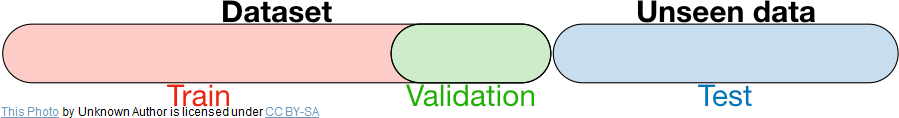

In [12]:
from IPython.core.display import Image
Image(filename='Img/Train-Test.png',width = 600, height = 800 )

You can use the Test data for validatation. 

## Split the data into training and test set

In [13]:
# train/test split
X_train, X_test, Y_train, Y_test = train_test_split(TC1data3, outcome,
                                                    train_size=0.75,
                                                    test_size=0.25,
                                                    random_state=123,
                                                    stratify = outcome)

## Let us define some parameters

* activation to be RELU
* batch_size is set to 20 
* number of classes is three (chosen a small number for performace) for this exercise. The code that is available from NIH FTP site will model 15 cancer site outputs.

In [14]:
# parameters
activation='relu'
batch_size=20
# Number of sites
classes=3

drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'

# metrics='accuracy'
out_act='softmax'

shuffle = False

### Note epochs should be greather than 10. For hands-on, I have chosen a smaller number

In [15]:
epochs=5
optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [16]:
x_train_len = X_train.shape[1]

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

### Please note that the `filters = 128` gave the best results. For the purpose of demonstration via cloud, I might choose a smaller number.

In [17]:
# filters = 128
filters = 128
filter_len = 20
stride = 1

K.clear_session()

## Create and initialize the model

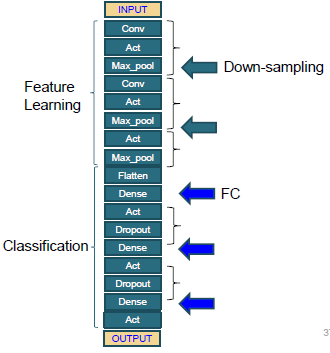

In [18]:
from IPython.core.display import Image
Image(filename='Img/TC1-arch.png',width = 300, height = 400 )

In [19]:
model = Sequential()

# model.add  1. CONV1D
model.add(Conv1D(filters = filters,
                 kernel_size = filter_len,
                 strides = stride,
                 padding='valid',
                 input_shape=(x_train_len, 1)))

## Create the topology of the architecture

In [20]:
# 2. Activation
model.add(Activation('relu'))

# 3. MaxPooling
model.add(MaxPooling1D(pool_size = 1))

# 4. Conv1D: filters:128, filter_len=20, stride=1
model.add(Conv1D(filters=filters,
                 kernel_size=filter_len,
                 strides=stride,
                 padding='valid'))

# 5. Activation
model.add(Activation('relu'))

# 6. MaxPooling
model.add(MaxPooling1D(pool_size = 10))

# 7. Flatten
model.add(Flatten())

# 8. Dense
model.add(Dense(200))

# 9. activation
model.add(Activation('relu'))

# 10. dropout
model.add(Dropout(0.1))

#11. Dense
model.add(Dense(20))

#12. Activation
model.add(Activation('relu'))

#13. dropout
model.add(Dropout(0.1))

# 14. dense
model.add(Dense(3))

# 15. Activation
model.add(Activation(out_act))

## Compile and show the model summary

In [21]:
model.compile( loss= loss,
              optimizer = optimizer,
              metrics = metrics )

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 60464, 128)        2688      
_________________________________________________________________
activation (Activation)      (None, 60464, 128)        0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 60464, 128)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60445, 128)        327808    
_________________________________________________________________
activation_1 (Activation)    (None, 60445, 128)        0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6044, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 773632)            0

In [22]:
# save
save = '.'
output_dir = "Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [23]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=10,
                              verbose=1, mode='auto',
                              min_delta=0.0001,
                              cooldown=0,
                              min_lr=0)

### This is a time-consuming step and smaller sample sizes will not result in good model. 
Here are the commands for training and evaluating test accuracy score.

In [24]:
# batch_size = 20; epochs=5
history = model.fit(X_train, Y_train, batch_size=batch_size,
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test),
                    callbacks = [checkpointer, csv_logger, reduce_lr])

Epoch 1/5
6/6 [==============================] - ETA: 0s - loss: 2.4082 - acc: 0.3482
Epoch 00001: val_loss improved from inf to 1.09860, saving model to Model/tc1.autosave.model.h5
6/6 [==============================] - 42s 7s/step - loss: 2.4082 - acc: 0.3482 - val_loss: 1.0986 - val_acc: 0.3158
Epoch 2/5
6/6 [==============================] - ETA: 0s - loss: 1.1030 - acc: 0.3036
Epoch 00002: val_loss did not improve from 1.09860
6/6 [==============================] - 42s 7s/step - loss: 1.1030 - acc: 0.3036 - val_loss: 1.0992 - val_acc: 0.3158
Epoch 3/5
6/6 [==============================] - ETA: 0s - loss: 1.0998 - acc: 0.2679
Epoch 00003: val_loss did not improve from 1.09860
6/6 [==============================] - 39s 7s/step - loss: 1.0998 - acc: 0.2679 - val_loss: 1.0998 - val_acc: 0.3158
Epoch 4/5
6/6 [==============================] - ETA: 0s - loss: 1.1003 - acc: 0.3304
Epoch 00004: val_loss did not improve from 1.09860
6/6 [==============================] - 39s 6s/step - los

In [25]:
score = model.evaluate(X_test, Y_test, verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.0993921756744385
Test accuracy: 0.31578946113586426


## Word of caution about the accuracy

The output loss and accuracy from smalller sample sizes (for example, n = 50) will not reflect the real learning. For good accuracy, we need to use the whole dataset. Here are few epochs from the original dataset modeling (Train: 3375; Validate: 1125).

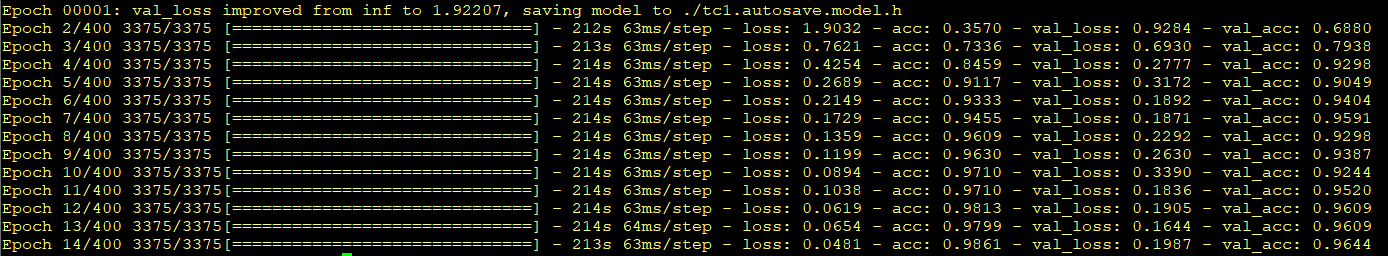

In [26]:
from IPython.core.display import Image
Image(filename='Img/TC1-Acc.PNG',width = 1000, height = 1000 )

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

tc1results = pd.read_csv("Output/tc1results.txt", index_col='epoch')

<AxesSubplot:xlabel='epoch'>

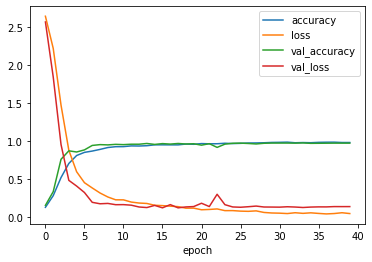

In [29]:
tc1results.plot()

## How to save the model/weights?

In [30]:
# JSON JSON
# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('Model/tc1.model.json', 'w') as json_file:
    json_file.write(json_model)


# YAML YAML
# serialize model to YAML
model_yaml = model.to_yaml()

# save the model architecture to YAML file
with open("{}/{}.model.yaml".format(output_dir, model_name), "w") as yaml_file:
    yaml_file.write(model_yaml)


# WEIGHTS HDF5
# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir, model_name))
print("Saved model to disk")

Saved model to disk


## Inference

The calculation was carried out on a NIH Biowulf GPU node. Model weights were saved in Python HDF5 grid format. HDF5 is ideal for storing multi-dimensional arrays of numbers. You can read about HDF5 here.
http://www.h5py.org/

In [31]:
from keras.models import model_from_json

# Open the handle
json_file = open('Model/tc1.model.json', 'r')

# load json and create model
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('Model/tc1.model.h5')
print("Loaded model from disk")
# loaded_model_json

Loaded model from disk


## Mimicking the process of external set

Note this is a demonstration of how to use external data for inference.  

When you bring in an external dataset. Make sure you follow the following steps:

a) Make sure you do the same operations that you had done to the data set 
b) scale the inference dataset in the same way as the training data 


In [32]:
import numpy as np
chosen_idx = np.random.choice(38, replace=False, size=5)
# X_test[chosen_idx].shape
# Y_test[chosen_idx].shape
# Y_test.shape

In [33]:
X_mini = X_test[chosen_idx]
y_mini = Y_test[chosen_idx]
# df_trimmed = X_mini.drop(X_mini.columns[[0]], axis=1, inplace=False)
# X_mini = df_trimmed
print('X_mini.shape', X_mini.shape)
print('len(y_minip)', len(y_mini))

X_mini.shape (5, 60483, 1)
len(y_minip) 5


In [34]:
print('X_mini.shape', X_mini.shape)
print('y_mini.shape', y_mini.shape)

X_mini.shape (5, 60483, 1)
y_mini.shape (5, 3)


In [35]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', 
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_mini, y_mini, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 40.00%


You are viewing the Jupyter Notebook from ML-TC1 GitHub repository, https://github.com/ravichas/ML-TC1 

# Andrew's additions

## Unsupervised learning plots (PCA and tSNE)

### Load the new tc1_library (`.py` file), which currently contains just the unsupervised learning plotting function

In [114]:
import tc1_library

# In case it was already loaded (for Andrew's debugging; you can leave this in here and it won't hurt anything)
import importlib
importlib.reload(tc1_library);

### Decode the outcome matrix back into a single vector (remember earlier that we one-hot-encoded it)

In [115]:
outcome_decoded = [x.argmax() for x in outcome]

### Perform the PCA using scikit-learn

Top 10 PCA explained variance ratios: [0.38811713 0.12041275 0.0499922  0.03027331 0.02528322 0.02271728
 0.01852503 0.01623522 0.01457017 0.0127146 ]


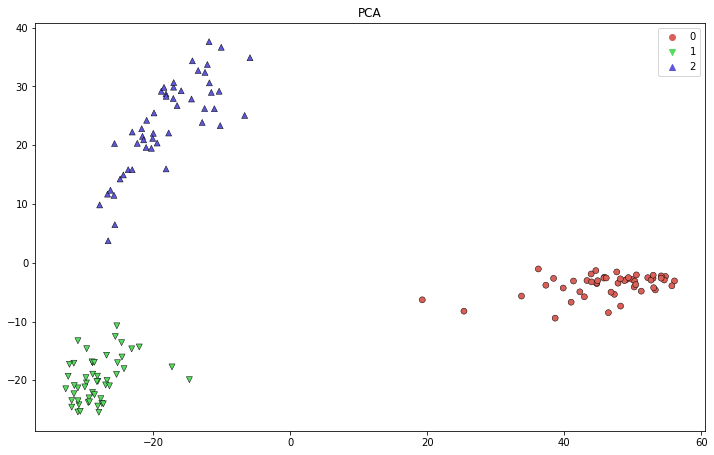

In [116]:
import sklearn.decomposition as sk_decomp
pca = sk_decomp.PCA(n_components=10)
pca_results = pca.fit_transform(TC1data3)
print('Top {} PCA explained variance ratios: {}'.format(10, pca.explained_variance_ratio_))
ax = tc1_library.plot_results(pca_results, outcome_decoded)
ax.set_title('PCA');

### Perform tSNE using scikit-learn

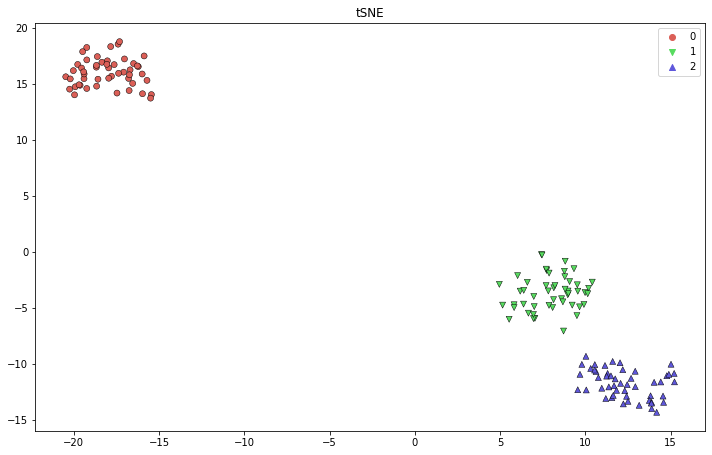

In [117]:
import sklearn.manifold as sk_manif
tsne = sk_manif.TSNE(n_components=2)
tsne_results = tsne.fit_transform(TC1data3.iloc[:,:500])
ax = tc1_library.plot_results(tsne_results, outcome_decoded)
ax.set_title('tSNE');

## Create a binary dataset instead of a multi-class one

### Current outcome distribution of the 150 samples

In [118]:
pd.value_counts(outcome_decoded)

2    50
1    50
0    50
dtype: int64

### Get the indexes of the data that correspond to classes 0 or 1 only (excluding class 2)

In [119]:
binary_indexes = np.where(np.array(outcome_decoded)!=2)[0]

### Recreate the data structures of the same types that Ravi used in the original analysis above, except this time with just two classes

In [120]:
TC1data2 = TC1data3.iloc[binary_indexes,:]
outcome2 = outcome[binary_indexes,:]

### Decode the new outcome matrix just like we did above, and print out the outcome distribution of the new set of samples

In [121]:
outcome_decoded2 = [x.argmax() for x in outcome2]
pd.value_counts(outcome_decoded2)

1    50
0    50
dtype: int64

### Check our new dataset by performing the same unsupervised learning that we did above

Top 10 PCA explained variance ratios: [0.49686232 0.04021868 0.03354306 0.03221508 0.02649847 0.01835524
 0.01706564 0.01658845 0.01310866 0.01188081]


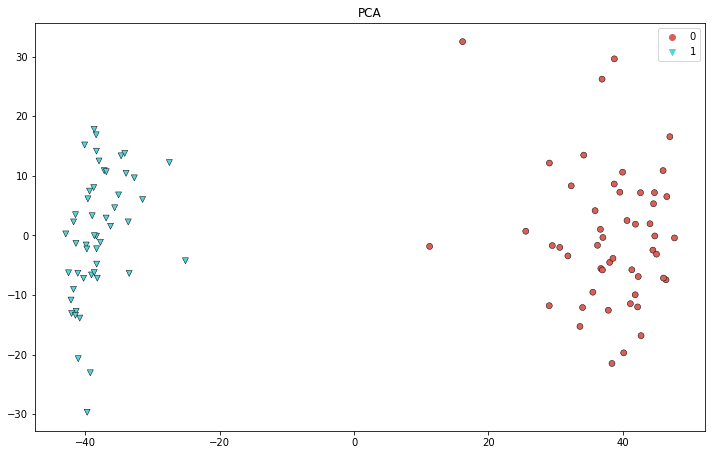

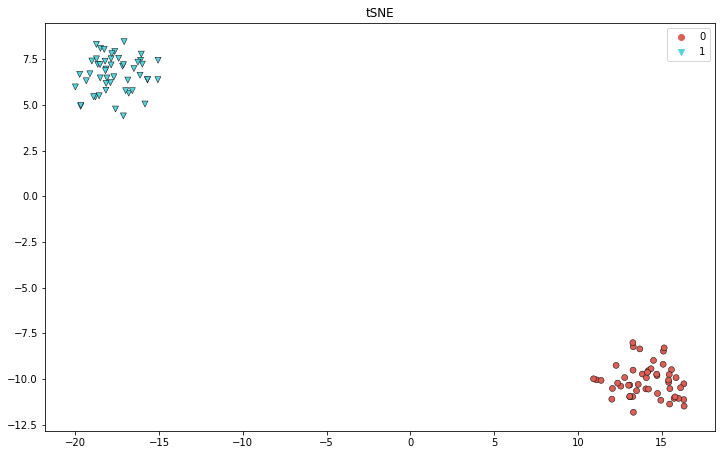

In [122]:
# Perform the PCA using scikit-learn
import sklearn.decomposition as sk_decomp
pca = sk_decomp.PCA(n_components=10)
pca_results = pca.fit_transform(TC1data2)
print('Top {} PCA explained variance ratios: {}'.format(10, pca.explained_variance_ratio_))
ax = tc1_library.plot_results(pca_results, outcome_decoded2)
ax.set_title('PCA');

# Perform tSNE using scikit-learn
import sklearn.manifold as sk_manif
tsne = sk_manif.TSNE(n_components=2)
tsne_results = tsne.fit_transform(TC1data2.iloc[:,:500])
ax = tc1_library.plot_results(tsne_results, outcome_decoded2)
ax.set_title('tSNE');

## Next steps

1. Pick up with the Jupyter notebook from the cell that splits the data into the training and test sets, but now replacing `TC1data3` with `TC1data2` and `outcome` with `outcome2`
1. Work through the notebook until at least the model has been trained (the cell with `history = model.fit(...)`), resulting in a binary classifier
1. Apply gene/feature importance tools to the resulting `model` in order to determine which genes best contribute to discriminating between cancer classes `0` and `1`